In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import interpolate
from calendar import monthrange

### Load the dataset (1-year, 2011)

In [46]:
# Load data
path = '/Users/robin/Code/ULG_2019/gym-smartgrid/gym_smartgrid/envs/smartgrid_env6/scenarios/preprocessing/nrel_rsf_2011.csv'
df = pd.read_csv(path)

In [47]:
df.head()

,Day of Week,Date and Time,Total Cooling (kW),Total Heating (kW),Total Mechanical (kW),Total Lighting (kW),Total Plug Loads (kW),Total Data Center (kW),Total Building (kW),PV (kW),Building Net (kW),Unnamed: 11
0,Saturday,1/1/2011 0:00,0,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
1,Saturday,1/1/2011 1:00,0,936,8.0,4.0,32.0,102.0,1080,0.0,1080.0,NaN
2,Saturday,1/1/2011 2:00,0,838,8.0,4.0,30.0,102.0,978,0.0,978.0,NaN
3,Saturday,1/1/2011 3:00,0,904,8.0,4.0,32.0,102.0,1046,0.0,1046.0,NaN
4,Saturday,1/1/2011 4:00,0,838,10.0,4.0,34.0,102.0,984,0.0,984.0,NaN


In [48]:
df.shape

(8760, 12)

### Select wanted data and pre-process it.

In [49]:
# Select only net consumption of the building.
df_consumption = df['Total Building (kW)'].values
print(type(df_consumption), df_consumption.shape)

<class 'numpy.ndarray'> (8760,)


In [52]:
# Remove NaNs.
for i in range(df_consumption.size):
    if df_consumption[i] == 0.:

        idx = i +1
        while df_consumption[idx] == 0.:
            idx += 1
            
        df_consumption[i] = df_consumption[idx]

In [53]:
# Normalize in [0, 1].
df_max = np.max(df_consumption)
df_min = np.min(df_consumption)
print('min:', df_min, '; max:', df_max)

sub_df = (df_consumption - df_min) / (df_max - df_min)
print(f'New range: [{np.min(sub_df)}, {np.max(sub_df)}]')

min: 94 ; max: 1852
New range: [0.0, 1.0]


In [54]:
curves_per_month = []

for month in range(12):
    max_day = monthrange(2011, month + 1)[1]
    month_curve = np.zeros(shape=(max_day, 24))

    for day in range(max_day):    
        if month:
            start_idx = (month - 1) * monthrange(2011, month)[1] * 24
        else:
            start_idx = 0    
        month_curve[day, :] = sub_df[start_idx: start_idx + 24]
    
    curves_per_month.append(month_curve)
    
print(len(curves_per_month), curves_per_month[0].shape)

12 (31, 24)


In [55]:
sum([l.size for l in curves_per_month])

8760

### Extrapolate data to have a 15-min resolution (instead of 1h).

In [69]:
extrapolated = []
for month in curves_per_month:
    new_month = []
    for day in month:
        tck = interpolate.splrep(np.arange(0, day.size, 1), day, k=2)
        extra_day = interpolate.splev(np.arange(0, day.size, 0.25), tck)
        
        # Clip all values in [0, 1.].
        extra_day[extra_day < 0.] = 0.
        extra_day[extra_day > 1.] = 1.
        
        new_month.append(extra_day)
        
    extrapolated.append(np.array(new_month))

In [70]:
print(min([np.min(a) for a in extrapolated]))

0.0


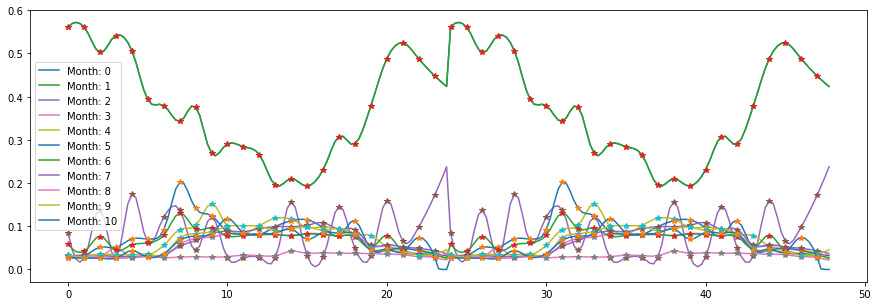

In [83]:
plt.figure(figsize=(15, 5))
for i in range(0, 11):
    c = list(extrapolated[i][0]) + list(extrapolated[i][1])
    original = list(curves_per_month[i][0]) + list(curves_per_month[i][1])
    plt.plot(np.arange(0, 48, 0.25), c, label=f'Month: {i}')
    plt.plot(np.arange(0, 48), original, '*')
plt.legend(loc='best')

### Save data to .csv files.

In [72]:
# Save to .csv files.
for i in range(12):
    folder = '/Users/robin/Code/ULG_2019/gym-smartgrid/gym_smartgrid/envs/smartgrid_env6/scenarios/data_demand_curves/factory'
    path = os.path.join(folder, f'curves_{i}.csv')
    np.savetxt(path, extrapolated[i], delimiter=",")